1.Data Extraction

In [183]:
import zipfile
import os

# unzip the picture files
zip_path = '/content/drive/MyDrive/jaffe.zip'
extract_path = '/content/FaceRecognition'

# open the zip and unpack everything
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


2.Core Libraries and Constants

In [184]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import hog
from skimage import exposure

# set up paths, image size, and emotion names
JAFFE_PATH = '/content/FaceRecognition/jaffe'
IMAGE_SIZE = (64, 64)

# connect file codes to emotion names
EMOTION_MAP = {
    'AN': 'anger',
    'DI': 'disgust',
    'FE': 'fear',
    'HA': 'happiness',
    'NE': 'neutral',
    'SA': 'sadness',
    'SU': 'surprise'
}

print("core libraries and constants loaded.")

core libraries and constants loaded.


3.Load Dataset Function Definition

In [185]:
# function to load pictures and their emotion names from a folder
def load_jaffe_dataset(folder_path, image_size=(64, 64), emotion_map=EMOTION_MAP):

    images = []
    labels = []

    # image file types to look for
    valid_extensions = ('.tiff', '.jpg', '.jpeg', '.png')

    # check if the folder exists
    if not os.path.exists(folder_path):
        print(f"error: dataset folder not found at {folder_path}")
        return np.array([]), np.array([])

    print(f"loading images from {folder_path}...")
    # go through each file
    for filename in os.listdir(folder_path):
        # process image files
        if filename.lower().endswith(valid_extensions):
            try:
                # get the emotion code from the filename
                parts = filename.split('.')
                if len(parts) > 1:
                    emotion_code = parts[1][:2].upper()
                else:
                    print(f"skipping {filename}: unexpected filename format.")
                    continue

                # get the emotion name
                emotion_label = emotion_map.get(emotion_code)

                if emotion_label:
                    # read and resize the grayscale image
                    img_path = os.path.join(folder_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None:
                        img = cv2.resize(img, image_size)
                        images.append(img)
                        labels.append(emotion_label)
                    else:
                        print(f"warning: could not read image file {filename}")
                else:
                    print(f"warning: unknown emotion code '{emotion_code}' in filename {filename}. skipping.")

            except Exception as e:
                print(f"skipping {filename} due to error: {e}")

    return np.array(images), np.array(labels)

4.Execute Data Loading

In [186]:
# load the images and labels
images, labels = load_jaffe_dataset(JAFFE_PATH)

# check if images were loaded
if len(images) > 0:
    print(f"successfully loaded {len(images)} images.")
    print(f"detected classes: {set(labels)}")

    # keep a copy of original images
    original_images = images.copy()

    y = labels

else:
    print("no images loaded. please check the dataset path and file formats.")
    original_images = np.array([])
    y = np.array([])

loading images from /content/FaceRecognition/jaffe...
successfully loaded 213 images.
detected classes: {np.str_('happiness'), np.str_('sadness'), np.str_('disgust'), np.str_('anger'), np.str_('surprise'), np.str_('neutral'), np.str_('fear')}


5.Canny and Harris Feature Extraction Function Definition

In [187]:
# function to extract canny edges and harris corners
def extract_canny_harris_features(images):

    if len(images) == 0:
        print("no images to extract canny/harris features from.")
        return np.array([]), np.array([]), np.array([])

    canny_features = []
    harris_features = []
    processed_images_list = []  # for visualization

    print("extracting canny and harris features...")
    # process each image
    for img in images:
        # find edges
        edges = cv2.Canny(img, threshold1=100, threshold2=200)

        # find corners
        img_float = np.float32(img)
        corners = cv2.cornerHarris(img_float, blockSize=2, ksize=3, k=0.04)

        # make corners more visible
        corners = cv2.dilate(corners, None)

        # normalize corner values
        corners_norm = cv2.normalize(corners, None, 0, 255, cv2.NORM_MINMAX)
        corners_uint8 = np.uint8(corners_norm)

        # combine edges and corners for a visual
        combined_visual = np.maximum(edges, corners_uint8)
        processed_images_list.append(combined_visual)

        # flatten features into lists of numbers
        canny_flat = edges.flatten()
        corner_flat = corners.flatten()

        # add features to lists
        canny_features.append(canny_flat)
        harris_features.append(corner_flat)

    return np.array(canny_features), np.array(harris_features), np.array(processed_images_list)

6.Execute Canny and Harris Extraction

In [188]:
# extract canny and harris features
canny_features, harris_features, processed_images = extract_canny_harris_features(images)

# check if features were extracted
if len(canny_features) > 0:
    print("canny and harris feature extraction complete.")
    print(f"canny feature shape: {canny_features.shape}")
    print(f"harris feature shape: {harris_features.shape}")
else:
    print("canny and harris feature extraction skipped (no images).")

extracting canny and harris features...
canny and harris feature extraction complete.
canny feature shape: (213, 4096)
harris feature shape: (213, 4096)


7.HOG Feature Extraction Function Definition

In [190]:
# function to extract hog features
def extract_hog_features(images):

    if len(images) == 0:
        print("no images to extract hog features from.")
        return np.array([])

    hog_features_list = []

    print("extracting hog features...")
    # process each image
    for img in images:
        # calculate hog features
        hog_feat = hog(img,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False)

        # add hog features to list
        hog_features_list.append(hog_feat)

    return np.array(hog_features_list)

8.Execute HOG Extraction

In [191]:
# extract hog features
hog_features = extract_hog_features(images)

# check if hog features were extracted
if len(hog_features) > 0:
    print("hog feature extraction complete.")
    print(f"hog feature shape: {hog_features.shape}")
else:
    print("hog feature extraction skipped (no images).")

extracting hog features...
hog feature extraction complete.
hog feature shape: (213, 1764)


9.Combine Features

In [192]:
# combine all extracted features into one set for each image
if len(canny_features) > 0 and len(harris_features) > 0 and len(hog_features) > 0:
    X = np.concatenate((canny_features, harris_features, hog_features), axis=1)
    print(f"combined feature shape: {X.shape}")
else:
    X = np.array([])
    print("feature combination skipped (missing features).")

combined feature shape: (213, 9956)


10.Data Preparation Function Definition

In [193]:
# function to get data ready for models
def prepare_dataset(X, y, original_images, processed_images, test_size=0.2, random_state=42):

    if len(X) == 0 or len(y) == 0:
        print("no data to prepare. skipping dataset preparation.")

        return np.array([]), np.array([]), np.array([]), np.array([]), \
               np.array([]), np.array([]), np.array([]), np.array([]), None

    # turn emotion names into numbers
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # check if enough data to split
    if len(X) < 2:
        print("not enough data to split. skipping dataset preparation.")
        return np.array([]), np.array([]), np.array([]), np.array([]), \
               np.array([]), np.array([]), np.array([]), np.array([]), le

    # check if enough samples per emotion for fair split
    unique_classes, counts = np.unique(y_encoded, return_counts=True)
    if any(counts < 2) or len(unique_classes) < 2 or (test_size > 0 and np.any(counts * test_size < 1)):
         print("not enough samples per class for stratified split. consider increasing dataset size or reducing test_size.")
         print("skipping dataset preparation due to insufficient samples for stratified split.")
         return np.array([]), np.array([]), np.array([]), np.array([]), \
               np.array([]), np.array([]), np.array([]), np.array([]), le


    print("preparing dataset (label encoding and train/test split)...")
    # split data for training and testing, keep emotion mix same
    X_train, X_test, y_train, y_test, orig_train, orig_test, proc_train, proc_test = train_test_split(
        X, y_encoded, original_images, processed_images,
        test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    return X_train, X_test, y_train, y_test, orig_train, orig_test, proc_train, proc_test, le

11.Execute Data Preparation

In [194]:
# prepare the data for the models
X_train, X_test, y_train, y_test, orig_train, orig_test, proc_train, proc_test, label_encoder = prepare_dataset(
    X, y, original_images, processed_images
)

# check if data is ready
if len(X_train) > 0:
    print("dataset preparation complete.")
    print(f"train samples: {len(X_train)}, test samples: {len(X_test)}")
    print(f"classes: {label_encoder.classes_}")  # show the emotion names now as numbers
else:
    print("dataset preparation skipped.")

preparing dataset (label encoding and train/test split)...
dataset preparation complete.
train samples: 170, test samples: 43
classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']


12.Model Training and Evaluation Function Definition

In [195]:
# function to train two models (k-nn and decision tree) and check their performance
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):

    if len(X_train) == 0 or len(y_train) == 0:
        print("no training data available. skipping model training.")
        return None, None, np.array([]), np.array([])

    print("training and evaluating models...")

    knn = None
    y_pred_knn = np.array([])
    dt = None
    y_pred_dt = np.array([])

    # try training k-nn
    try:
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        acc_knn = accuracy_score(y_test, y_pred_knn)
        print(f"\nk-nn accuracy: {acc_knn:.4f}")
    except Exception as e:
        print(f"error training k-nn model: {e}")

    # try training decision tree
    try:
        dt = DecisionTreeClassifier(random_state=42)
        dt.fit(X_train, y_train)
        y_pred_dt = dt.predict(X_test)
        acc_dt = accuracy_score(y_test, y_pred_dt)
        print(f"\ndecision tree accuracy: {acc_dt:.4f}")
    except Exception as e:
        print(f"error training decision tree model: {e}")

    print("model training and evaluation complete.")

    return knn, dt, y_pred_knn, y_pred_dt

13.Execute Model Training and Evaluation

In [196]:
# train the models and get their test predictions
knn_model, dt_model, y_pred_knn, y_pred_dt = train_and_evaluate_models(
    X_train, X_test, y_train, y_test, label_encoder
)

training and evaluating models...

k-nn accuracy: 0.5116

decision tree accuracy: 0.5349
model training and evaluation complete.


14.Confusion Matrix Plotting Function Definition

In [197]:
# function to draw a confusion matrix (shows how models mixed up emotions)
def plot_confusion_matrix(y_true, y_pred, class_names, title):

    if len(y_true) == 0 or len(y_pred) == 0 or len(class_names) == 0:
        print(f"cannot plot confusion matrix for '{title}': missing data.")
        return

    try:
        # calculate the matrix numbers and draw it
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
        # add title and show
        plt.title(title)
        plt.show()
    except Exception as e:

        print(f"error plotting confusion matrix for '{title}': {e}")

15.Execute Confusion Matrix Plots and Classification Reports

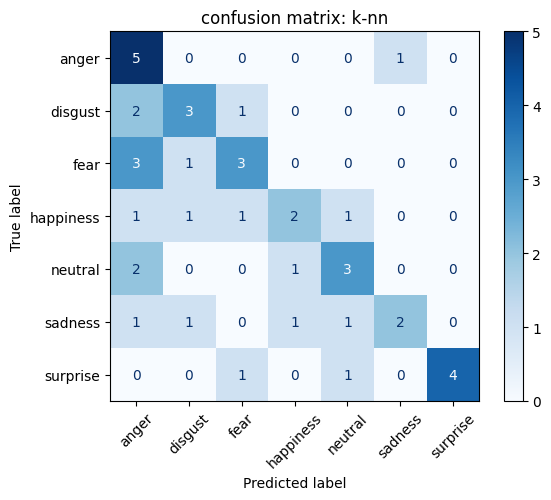

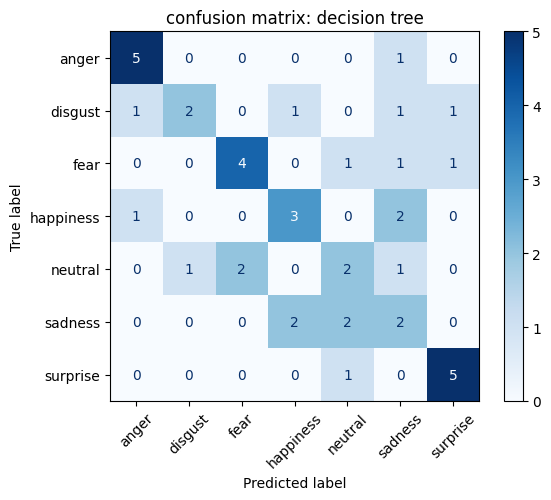

classification report for k-nn:
              precision    recall  f1-score   support

       anger       0.36      0.83      0.50         6
     disgust       0.50      0.50      0.50         6
        fear       0.50      0.43      0.46         7
   happiness       0.50      0.33      0.40         6
     neutral       0.50      0.50      0.50         6
     sadness       0.67      0.33      0.44         6
    surprise       1.00      0.67      0.80         6

    accuracy                           0.51        43
   macro avg       0.57      0.51      0.52        43
weighted avg       0.57      0.51      0.51        43


classification report for decision tree:
              precision    recall  f1-score   support

       anger       0.71      0.83      0.77         6
     disgust       0.67      0.33      0.44         6
        fear       0.67      0.57      0.62         7
   happiness       0.50      0.50      0.50         6
     neutral       0.33      0.33      0.33         6
    

In [198]:
# check if we have test data and predictions to show results
if len(y_test) > 0 and len(y_pred_knn) == len(y_test) and len(y_pred_dt) == len(y_test):
    # show k-nn confusion matrix
    plot_confusion_matrix(y_test, y_pred_knn, label_encoder.classes_, "confusion matrix: k-nn")

    # show decision tree confusion matrix
    plot_confusion_matrix(y_test, y_pred_dt, label_encoder.classes_, "confusion matrix: decision tree")

    print("classification report for k-nn:")
    print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

    print("\nclassification report for decision tree:")
    print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))

else:
    print("skipping confusion matrix plots and classification reports due to missing test data or predictions.")

16.Visualization Function Definition

In [199]:
# function to show example pictures, their real feeling, model guesses, and features
def visualize_predictions_knn_dt_separate(orig_images, true_labels, pred_knn, pred_dt, class_names, num_samples=5):

    if len(orig_images) == 0 or len(true_labels) == 0 or len(pred_knn) == 0 or len(pred_dt) == 0 or len(class_names) == 0:
        print("cannot visualize predictions: missing data.")
        return

    print(f"visualizing {min(num_samples, len(orig_images))} sample predictions...")
    # set up the drawing area
    plt.figure(figsize=(20, min(num_samples, len(orig_images)) * 4))

    # figure out how many to show
    num_samples_to_plot = min(num_samples, len(orig_images))
    if num_samples_to_plot <= 0:
        print("no samples to visualize.")
        return

    # pick random pictures to show
    random_indices = np.random.choice(len(orig_images), size=num_samples_to_plot, replace=False)

    # for each chosen picture
    for i, idx in enumerate(random_indices):
        # get real emotion and model guesses
        true_label = class_names[true_labels[idx]]
        knn_label = class_names[pred_knn[idx]]
        dt_label = class_names[pred_dt[idx]]

        # set color based on if guess was right (green) or wrong (red)
        knn_color = 'green' if knn_label == true_label else 'red'
        dt_color = 'green' if dt_label == true_label else 'red'

        # get the original picture
        original = orig_images[idx]

        # get edges
        edges = cv2.Canny(original, threshold1=100, threshold2=200)

        # get corners
        img_float = np.float32(original)
        corners = cv2.cornerHarris(img_float, blockSize=2, ksize=3, k=0.04)
        corners = cv2.dilate(corners, None)
        corners_norm = cv2.normalize(corners, None, 0, 255, cv2.NORM_MINMAX)
        corners_uint8 = np.uint8(corners_norm)

        # get hog view
        try:
            _, hog_img = hog(
                original,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True
            )
            hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
        except Exception as e:
            # show black if hog fails
            print(f"error generating hog visualization for sample {idx}: {e}. showing black image.")
            hog_img_rescaled = np.zeros_like(original)


        # create title with real emotion and guesses
        title_text = f"true: {true_label}\nknn: {knn_label} | dt: {dt_label}"

        # show original with title
        plt.subplot(num_samples_to_plot, 4, i * 4 + 1)
        plt.imshow(original, cmap='gray')
        plt.title(title_text, color='blue')
        plt.axis('off')

        # show canny edges title red if k-nn was wrong
        plt.subplot(num_samples_to_plot, 4, i * 4 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title("canny edges", color=knn_color if knn_label != true_label else 'black')
        plt.axis('off')

        # show harris corners title red if decision tree was wrong
        plt.subplot(num_samples_to_plot, 4, i * 4 + 3)
        plt.imshow(corners_uint8, cmap='gray')
        plt.title("harris corners", color=dt_color if dt_label != true_label else 'black')
        plt.axis('off')

        # show hog view
        plt.subplot(num_samples_to_plot, 4, i * 4 + 4)
        plt.imshow(hog_img_rescaled, cmap='gray')
        plt.title("hog viz", color='black')
        plt.axis('off')

    # add overall title and show the plot
    plt.suptitle("original | canny edges | harris corners | hog viz\n(true, k-nn prediction, dt prediction)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

17.Execute Visualization

visualizing 10 sample predictions...


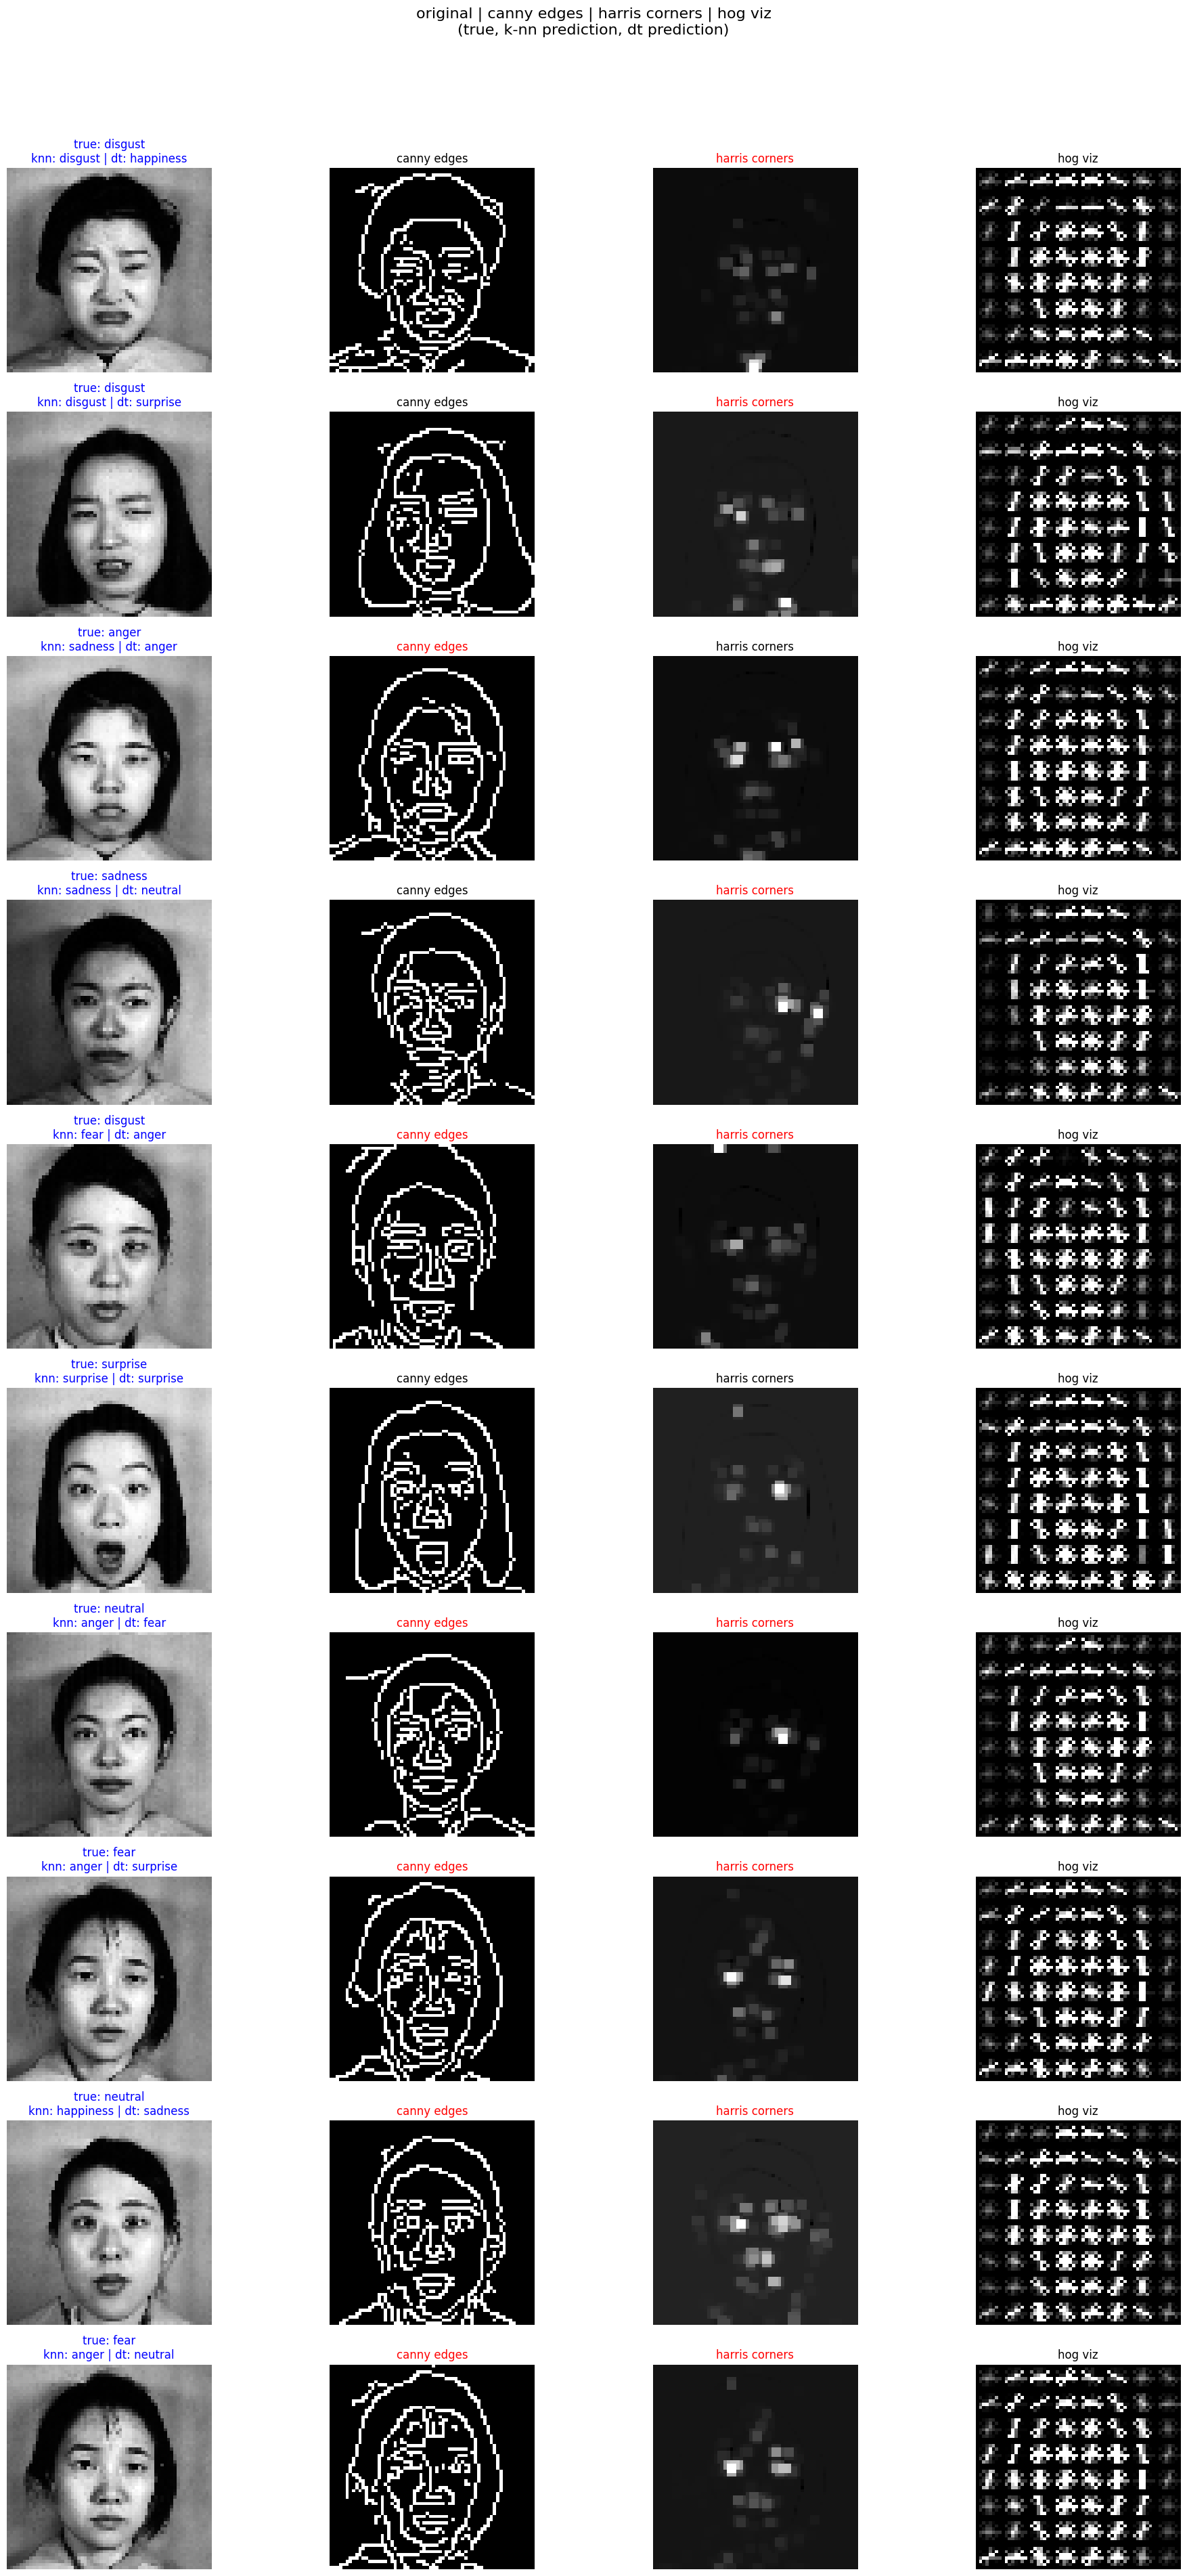

In [200]:
# show example results if all data is ready
if len(orig_test) > 0 and len(y_test) > 0 and len(y_pred_knn) > 0 and len(y_pred_dt) > 0 and label_encoder is not None:
    visualize_predictions_knn_dt_separate(
        orig_images=orig_test,
        true_labels=y_test,
        pred_knn=y_pred_knn,
        pred_dt=y_pred_dt,
        class_names=label_encoder.classes_,
        num_samples=10
    )
else:
      print("skipping visualization due to missing test data or predictions.")